# WeRateDogs Twitter Data Wrangling

First, we need to download the predictions

In [1]:
import requests

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url, allow_redirects=True)
open('image_predictions.tsv', 'wb').write(r.content)

335079

## Getting Data
I was asked to paste the following code. However, the data is in the `tweet-json.txt` file

In [2]:
import pandas as pd
import numpy as np
import json
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [3]:
df_1 = pd.read_csv('twitter-archive-enhanced.csv')
df_1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...",12,10,Franklin,None,None,None,None


In [4]:
predict_df = pd.read_csv('image_predictions.tsv', sep='\t')
predict_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [5]:
# import tweepy
# from tweepy import OAuthHandler
# import json
# from timeit import default_timer as timer

# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

# # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# # NOTE TO REVIEWER: this student had mobile verification issues so the following
# # Twitter API code was sent to this student from a Udacity instructor
# # Tweet IDs for which to gather additional data via Twitter's API
# tweet_ids = df_1.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepError as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)

In [6]:
with open('tweet-json.txt', 'r') as tweet_json:
    tweets_dict = [json.loads(tweet) for tweet in tweet_json]

print(len(tweets_dict))

2354


In [7]:
tweets_dict[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'large': {'w': 540, 'h': 528, 'resize': 'fit'},
     'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'medium': {'w': 

In [8]:
tweets = pd.DataFrame(tweets_dict) #[['id', 'retweet_count', 'favorite_count']]
tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89242063948687...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,8853,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89217741319462...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,6514,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89181517537179...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,4328,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89168955272479...","{'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,8964,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], ...","{'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,9774,41048,False,False,False,False,en,NaN,NaN,NaN,NaN


## Data Assessment

In [9]:
# df_1: enhanced archive
# predict_df: predictions
# tweets: json data

In [10]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Please refer to <a href="#Introduction_1">Observations</a> for remarks

Now looking at rating columns

In [11]:
df_1[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


Please refer to <a href="#Introduction_1">Observations</a> for remarks

Now looking at the stage-related columns

In [12]:
df_1.iloc[:,13:].nunique()

doggo      2
floofer    2
pupper     2
puppo      2
dtype: int64

In [13]:
for i in range(13,17):
    print(i, ':', df_1.iloc[:,i].nunique(), df_1.iloc[:,i].unique())

13 : 2 ['None' 'doggo']
14 : 2 ['None' 'floofer']
15 : 2 ['None' 'pupper']
16 : 2 ['None' 'puppo']


It seems that these 4 columns act as dummy columns with 2 possible values (None or *column_title*). However, further inspection is required

In [14]:
tmp = df_1.iloc[:,13:].copy()

In [15]:
tmp = df_1.iloc[:,13:].applymap(lambda x: np.nan if x=='None' else x)
tmp.head()

,doggo,floofer,pupper,puppo
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [16]:
tmp.isnull().sum(axis=1).value_counts()

4    1976
3     366
2      14
dtype: int64

Please refer to <a href="#Introduction_1">Observations</a> for remarks

The following is another way of doing the same verification for 'None's

In [17]:
tmp = df_1.iloc[:,13:].applymap(lambda x: x=='None')
tmp.sum(axis=1).value_counts()

4    1976
3     366
2      14
dtype: int64

Please refer to <a href="#Introduction_1">Observations</a> for remarks

Now looking at the name column

In [18]:
df_1.iloc[:,12].apply(lambda x: x=='None').sum()

745

<h2 id="Introduction_1">Observations Regarding Quality and Tidiness of Archive Data:</h2>

### Quality Issues 
<ol>
    <li> <mark>timestamp</mark>is object but should be datetime.</li>
    <li><mark>retweeted_status_timestamp</mark> is object but should be datetime.</li>
    <li>The <mark>expanded_urls</mark> column is missing 59 entries, which should be removed</li>
    <li>The <mark>rating_denominator</mark> values should be always 10 by definition. However, some are not (min: 0, max:170), which needs to be removed</li>
    <li>The <mark>rating_numerator</mark> should be <strong>usually</strong> greater than 10 by definition. However, the minimum value isn't conforming (zero), which needs to be removed. While the maximum is a bit off at 1776. So, I think a wisker plot or a histogram needs to be used to remove outliers</li>
    <li>There is an inconsistency problem between rating_numerator column and the data downloaded from Twitter API. Therefore, data needs to be reparsed from API data.</li>
    <li>The stage-related columns i.e. <mark>doggo, floofer, pupper, puppo</mark> are filled with rows of completely missing values (all values are None on these rows). There are 1976 such rows. The problem is that these are the majority of rows, so unfortuantely they cannot be deleted, as the constitute about 84% of the data. Also, it might be the case that this wouldn't be considered an issue to begin with (if names were not available on Twitter  itself).</li>
    <li>The stage-related columns have another issue: some rows are filled with more than one stage vaule (14 such rows)</li>
    <li>The name column has 745 values of None. As with a previous point (point 7), unfortunately, that is a very large chunk of the data. Not sure if it is best to remove those rows. Again! It might be the case that this wouldn't be considered an issue to begin with (if names were not available on Twitter  itself).</li>
<li>links in full_text column are not working</li>
</ol>

### Tidiness Issues
<ol> 
    <li>The <mark>display_text_range</mark> column contains 2 variables and should be split into 2 columns</li>
    <li>The <mark>source</mark> column is duplicated between the archive and the tweets tables. It needs to be dropped from tweets.</li>
</ol>

In [19]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


I don't see a problem with the predictions dataframe

In [20]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2354 non-null   object 
 1   id                             2354 non-null   int64  
 2   id_str                         2354 non-null   object 
 3   full_text                      2354 non-null   object 
 4   truncated                      2354 non-null   bool   
 5   display_text_range             2354 non-null   object 
 6   entities                       2354 non-null   object 
 7   extended_entities              2073 non-null   object 
 8   source                         2354 non-null   object 
 9   in_reply_to_status_id          78 non-null     float64
 10  in_reply_to_status_id_str      78 non-null     object 
 11  in_reply_to_user_id            78 non-null     float64
 12  in_reply_to_user_id_str        78 non-null     o

In [21]:
tweets.head()

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89242063948687...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,8853,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...",False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89217741319462...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,6514,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89181517537179...","{'media': [{'id': 891815175371796480, 'id_str': '891815175371796480', 'indices': [122, 145], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,4328,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 89168955272479...","{'media': [{'id': 891689552724799489, 'id_str': '891689552724799489', 'indices': [80, 103], 'med...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,8964,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and sh...",False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}], 'symbols': [], 'user_mentions': [], ...","{'media': [{'id': 891327551943041024, 'id_str': '891327551943041024', 'indices': [139, 162], 'me...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,None,NaN,None,None,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™ (author)', 'screen_name': 'dog_r...",None,None,None,None,False,9774,41048,False,False,False,False,en,NaN,NaN,NaN,NaN


In [22]:
tweets['full_text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

In [23]:
(tweets['id'] - tweets['id_str'].apply(int)).sum()

0

### Other ideas that potentially can be fixed
I have listed here a list of the issues that were possibly going to be highlighted had I not reached the goal of this project (10 quality and 2 tidiness issues).
<ul>
    <li>id vs id_str column (might introduce contradictions as they might not be matching)</li>
    <li>id vs id_str  (what is the purpose of the duplicity) one column should be removed</li>
    <li>retweets_status etc. can be split into a different pivoted dataframe</li>
    <li>entities can be combined with entities_extended</li>
    <li>entities + entities_extended can be split into a different frame</li>
    <li>quoting can be split too</li>
    <li>scores can be extracted from the full_text column</li>
    <li>The <mark>name</mark> column needs to be moved into a separate dataframe. (since not every row has a  <mark>name</mark> value associated with it</li>
    <li>The stage-related columns needs to be moved into a separate dataframe. (since not every row has a value associated with it</li>
    <li>many reply-related columns like <mark>in_reply_to_status_id</mark> and <mark>in_reply_to_user_id</mark> are full of nulls (missing values). This is expected as not all tweets get replied to. These columns should be split into a separate pivoted dataframe</li>
    <li>many retweet-related columns like <mark>retweeted_status_id</mark> and <mark>retweeted_status_user_id</mark> and <mark>retweeted_status_timestamp</mark> are full of nulls (missing values). This is expected as not all tweets get retweeted. These columns should be split into a separate pivoted dataframe</li>
</ul>
    








## Cleaning Data
All fixes are going to be to the archive file data.<br>
<br>
Clean data is going to be stored in the clean dataframe

In [24]:
clean = df_1.copy()

### Quality Issues

##### First, <mark>timestamp</mark>is object but should be datetime.

In [25]:
clean['timestamp'] = pd.to_datetime(clean['timestamp'])

##### Second, <mark>retweeted_status_timestamp</mark>is object but should be datetime.

In [26]:
clean['retweeted_status_timestamp'] = pd.to_datetime(
    clean['retweeted_status_timestamp']
)

In [27]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

This confirms the first 2 issues are resolved

##### Next, the <mark>expanded_urls</mark> column is missing 59 entries, which should be removed

In [28]:
clean = clean.drop(clean[clean.expanded_urls.isnull()].index)
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

Issue resolved sucessfully

##### Next, the <mark>rating_denominator</mark> values should be always 10 by definition. However, some are not (min: 0, max:170), which needs to be removed

In [29]:
clean = clean.drop(clean[clean.rating_denominator != 10].index)

In [30]:
len(clean[clean.rating_denominator != 10].index)

0

Rows deleted sucessfully

##### Next, the <mark>rating_numerator</mark> should be greater than 10 by definition. However, the minimum value isn't conforming (zero), which needs to be removed. While the maximum is a bit off at 1776. So, I think a wisker plot or a histogram needs to be used to remove outliers







In [31]:
clean[clean.rating_numerator <= 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite...",NaN,NaN,NaT,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/st...",5,10,Bella,None,None,None,None
165,860177593139703809,NaN,NaN,2017-05-04 17:01:34+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Ohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboyohboy. 10/1...,7.616730e+17,4.196984e+09,2016-08-05 21:19:27+00:00,https://twitter.com/dog_rates/status/761672994376806400/video/1,10,10,None,None,None,None,None
212,851861385021730816,NaN,NaN,2017-04-11 18:15:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @eddie_coe98: Thanks @dog_rates completed my laptop. 10/10 would buy again https://t.co/bO0rT...,8.482894e+17,3.410211e+08,2017-04-01 21:42:03+00:00,"https://twitter.com/eddie_coe98/status/848289382176100353/photo/1,https://twitter.com/eddie_coe9...",10,10,None,None,None,None,None
229,848212111729840128,NaN,NaN,2017-04-01 16:35:01+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you'r...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/848212111729840128/photo/1,6,10,Jerry,None,None,None,None
232,847962785489326080,NaN,NaN,2017-04-01 00:04:17+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Georgie. He's very shy. Only puppears when called. Aggressively average at fetch. Unique...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/847962785489326080/photo/1,10,10,Georgie,None,None,None,None
275,840696689258311684,NaN,NaN,2017-03-11 22:51:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I didn't even have to intervene. Took him 4 minutes to realize his error. 10/10 for Kevin https:...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/840696689258311684/photo/1,10,10,None,None,None,None,None
281,839290600511926273,NaN,NaN,2017-03-08 01:44:07+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @alexmartindawg: THE DRINK IS DR. PUPPER 10/10 good pun @matt___nelson @GoodDogsGame https://...,8.392899e+17,4.119842e+07,2017-03-08 01:41:24+00:00,"https://twitter.com/alexmartindawg/status/839289919298224128/photo/1,https://twitter.com/alexmar...",10,10,None,None,None,pupper,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https:...,NaN,NaN,NaT,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/st...",0,10,None,None,None,None,None
323,834089966724603904,NaN,NaN,2017-02-21 17:18:39+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",DOGGO ON THE LOOSE I REPEAT DOGGO ON THE LOOSE 10/10 https://t.co/ffIH2WxwF0,NaN,NaN,NaT,https://twitter.com/stevekopack/status/834086676934836224,10,10,None,doggo,None,None,None
335,832645525019123713,NaN,NaN,2017-02-17 17:38:57+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp...,NaN,NaN,NaT,http://us.blastingnews.com/news/2017/02/jfk-announces-its-first-ever-ark-oasis-animal-terminal-0...,10,10

Upon further investigation, it seems that whenever the actual rating contains a decimal numerator, the archive tends to misparse it (as can be seen from the following)

In [32]:
clean[clean.tweet_id == 883482846933004288]['rating_numerator']

45    5
Name: rating_numerator, dtype: int64

In [33]:
tweets[tweets.id == 883482846933004288]['full_text'].values

array(['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948'],
      dtype=object)

As can be seen above, a 13.5 became a 5 in the archive. This means that ratings need to be reparsed from tweets again.

In [34]:
# idx = 3,6, 41
# patterns : r'[.]\D*([0-9.]*)/[0-9]*.*http'
# r'[.]\D*([0-9.]*)/[0-9]'
# r'[.]*\D*([0-9.]*)/[0-9]'

tweets['full_text'][41]

"OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY 13/10 WOULD FORGIVE IMMEDIATE https://t.co/uF3pQ8Wubj"

In [35]:
tweets['rating'] = tweets['full_text'].str.extract(r'[.]*\D*([0-9.]*)/[0-9]')

In [36]:
clean = clean.merge(tweets[['id', 'rating']],
                    how='left',
                    left_on='tweet_id',
                    right_on='id')

In [37]:
# Converting column type from string to float
clean['rating'] = clean['rating'].astype(float)

In [38]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2277
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2278 non-null   int64              
 1   in_reply_to_status_id       22 non-null     float64            
 2   in_reply_to_user_id         22 non-null     float64            
 3   timestamp                   2278 non-null   datetime64[ns, UTC]
 4   source                      2278 non-null   object             
 5   text                        2278 non-null   object             
 6   retweeted_status_id         179 non-null    float64            
 7   retweeted_status_user_id    179 non-null    float64            
 8   retweeted_status_timestamp  179 non-null    datetime64[ns, UTC]
 9   expanded_urls               2278 non-null   object             
 10  rating_numerator            2278 non-null   int64           

In [39]:
clean[clean.rating <= 10.]['rating'].value_counts()

10.00    455
9.00     154
8.00     102
7.00      52
5.00      34
6.00      32
3.00      19
4.00      15
2.00       9
1.00       5
9.75       2
0.00       2
Name: rating, dtype: int64

In [40]:
len(clean[clean.rating <= 10.]['rating'].index)

881

It seems that most numbers are fine now. Out of 2276 only 2 are zeros and 879 are less than 10. Also, upon revising the rating convention, it seems that the numerator can take values less than 10. So, potentially the 2 rows with zeros can be removed. However, I will keep them as zero values are not explicitly against the convention. However, I will replace the old rating_numerator column with the new values. The last remaining issue is the very high values

In [41]:
clean['rating_numerator'] = clean['rating']

In [42]:
clean = clean.drop(['rating', 'id'],axis=1, errors='ignore')

In [43]:
import matplotlib.pylab as plt

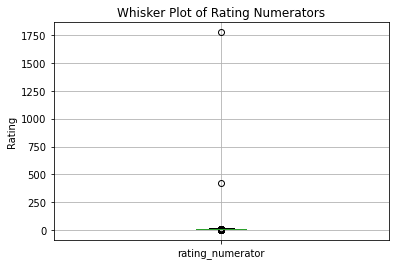

In [44]:
clean.boxplot(column='rating_numerator');
plt.title('Whisker Plot of Rating Numerators');
plt.ylabel('Rating');

As can be seen from the plot, all values are close to each other except for those values above 250.

In [45]:
clean[clean.rating_numerator > 250]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
942,749981277374128128,NaN,NaN,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaT,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10,Atticus,None,None,None,None
2000,670842764863651840,NaN,NaN,2015-11-29 05:52:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,NaN,NaN,NaT,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420.0,10,None,None,None,None,None


So, we will drop these 2 rows

In [46]:
clean = clean.drop(clean[clean.rating_numerator > 250].index)

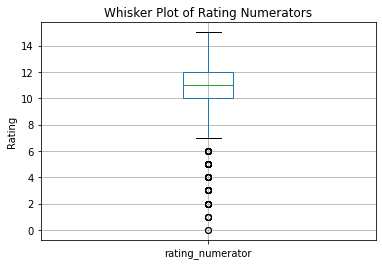

In [47]:
clean.boxplot(column='rating_numerator');
plt.title('Whisker Plot of Rating Numerators');
plt.ylabel('Rating');

Much better now!

In [48]:
clean[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2274.000000,2276.0
mean,10.703399,10.0
std,2.143188,0.0
min,0.000000,10.0
25%,10.000000,10.0
50%,11.000000,10.0
75%,12.000000,10.0
max,15.000000,10.0


In [49]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276 entries, 0 to 2277
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2276 non-null   int64              
 1   in_reply_to_status_id       22 non-null     float64            
 2   in_reply_to_user_id         22 non-null     float64            
 3   timestamp                   2276 non-null   datetime64[ns, UTC]
 4   source                      2276 non-null   object             
 5   text                        2276 non-null   object             
 6   retweeted_status_id         179 non-null    float64            
 7   retweeted_status_user_id    179 non-null    float64            
 8   retweeted_status_timestamp  179 non-null    datetime64[ns, UTC]
 9   expanded_urls               2276 non-null   object             
 10  rating_numerator            2274 non-null   float64         

##### Next, the stage-related columns have another issue: some rows are filled with more than one stage vaule (14 such rows)

In [50]:
clean_tmp = clean.iloc[:,13:].applymap(lambda x: x=='None')
clean_tmp.sum(axis=1).value_counts()

4    1902
3     360
2      14
dtype: int64

In [51]:
columns_of_interest = [
    'tweet_id',
    'text',
    'doggo',
    'floofer',
    'pupper', 
    'puppo'
]
clean[columns_of_interest][clean_tmp.sum(axis=1) == 2]

,tweet_id,text,doggo,floofer,pupper,puppo
181,855851453814013952,Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/...,doggo,None,None,puppo
190,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs...",doggo,floofer,None,None
436,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow ...",doggo,None,pupper,None
504,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/1...,doggo,None,pupper,None
538,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",doggo,None,pupper,None
547,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths ...,doggo,None,pupper,None
674,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your aver...,doggo,None,pupper,None
701,781308096455073793,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",doggo,None,pupper,None
746,775898661951791106,"RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,None,pupper,None
789,770093767776997377,RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/...,doggo,None,pupper,None


In [52]:
clean[columns_of_interest][clean_tmp.sum(axis=1) == 2]['tweet_id']

181     855851453814013952
190     854010172552949760
436     817777686764523521
504     808106460588765185
538     802265048156610565
547     801115127852503040
674     785639753186217984
701     781308096455073793
746     775898661951791106
789     770093767776997377
854     759793422261743616
920     751583847268179968
1025    741067306818797568
1073    733109485275860992
Name: tweet_id, dtype: int64

It seems from the rows above that these are legit cases where more than one stage is applicable at the same time. For example, when an image shows 2 different dogs from 2 different stages. Another case is when a dog from a stage is posing/pretending to be from another stage.

However, this doesn't eliminate the chance that there could be an error here. So, since the number of such cases is small (only 14), I will manually check the tweets and their images on the website and modify the stage-related columns accordingly.

In [53]:
clean[columns_of_interest][clean_tmp.sum(axis=1) == 2].text.values

array(["Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel",
       "At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",
       'This is Dido. She\'s playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7',
       'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho',
       'Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze',
       "This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj",
       "This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier 

According to the manual inspection, There were a few issues/mistakes, which were probably introduced by the simplistic parsing algorithm. I will list the issues below:

In [54]:
issues = pd.read_csv('issues.csv')
display(issues)

,tweet_id,Issue
0,855851453814013952,Puppo is correct. Doggo is not
1,854010172552949760,Doggo is wrong. Floofer is correct
2,817777686764523521,Pupper is correct. Doggo is not
3,808106460588765185,None
4,802265048156610565,None
5,801115127852503040,Pupper is correct. Doggo is not
6,785639753186217984,Pupper is correct. Doggo is not
7,781308096455073793,Ambiguous
8,775898661951791106,None
9,770093767776997377,None


As can be seen, there are 6 mistakes and 1 ambiguouity and 7 are in fact correctly having multiple stages filled. Now, we fix issues.

This should fix the 6 mistakes

In [55]:
wrong_doggo_lst = [855851453814013952,
                   854010172552949760,
                   817777686764523521,
                   801115127852503040,
                   785639753186217984]
wrong_pupper_lst = [751583847268179968]
for idx in clean[columns_of_interest][clean_tmp.sum(axis=1) == 2].index:
    current_id = int(clean['tweet_id'][idx])
    column_of_interest = None
    
    print(current_id, type(current_id))
    
    
    if current_id in wrong_doggo_lst:
        column_of_interest = 'doggo'
        
    elif current_id in wrong_pupper_lst:
        column_of_interest = 'pupper'
    else:
        continue
    
    # Sanity check (before change)
    print('before: ', clean[column_of_interest][idx], end=' ')
    
    # Fixing issue here...
    clean[column_of_interest][idx] = 'None'
    
    # Sanity check (after change)
    print('after: ', clean[column_of_interest][idx])


855851453814013952 <class 'int'>
before:  doggo after:  None
854010172552949760 <class 'int'>
before:  doggo after:  None
817777686764523521 <class 'int'>
before:  doggo after:  None
808106460588765185 <class 'int'>
802265048156610565 <class 'int'>
801115127852503040 <class 'int'>
before:  doggo after:  None
785639753186217984 <class 'int'>
before:  doggo after:  None
781308096455073793 <class 'int'>
775898661951791106 <class 'int'>
770093767776997377 <class 'int'>
759793422261743616 <class 'int'>
751583847268179968 <class 'int'>
before:  pupper after:  None
741067306818797568 <class 'int'>
733109485275860992 <class 'int'>


C:\Users\Mohammed\anaconda3\envs\DANDP5_Dog\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [56]:
clean_tmp = clean.iloc[:,13:].applymap(lambda x: x=='None')
clean_tmp.sum(axis=1).value_counts()

4    1902
3     366
2       8
dtype: int64

All set! The 6 mistakes are gone. Now all that remains is the ambiguous one (which contained no image and vague description). I've chosen to delete it because I want to make sure that the remaining data is correct.

In [57]:
clean = clean.drop(clean[clean.tweet_id == 781308096455073793].index, axis=0)

In [58]:
clean_tmp = clean.iloc[:,13:].applymap(lambda x: x=='None')
clean_tmp.sum(axis=1).value_counts()

4    1902
3     366
2       7
dtype: int64

Done!

There are no more row deletions are going to be made here! 
#### Invalid Names
I will start by sampling the `name` column for a basic visual inspection.

In [59]:
columns_of_interest = ['tweet_id', 'name']
clean[columns_of_interest].sample(10)

,tweet_id,name
44,883482846933004288,Bella
1910,672964561327235073,Terry
417,819711362133872643,Howie
47,882992080364220416,Rusty
667,786595970293370880,Dale
1823,674754018082705410,None
54,881536004380872706,a
1199,711968124745228288,Winston
920,751583847268179968,None
2009,670811965569282048,Maggie


It seems that there are a few issues with the name column. For example, by sampling the column a few times, I noticed the following case (index=1333) with the name of "a". Also, another case is (index=1964) with the name of "the".

In [60]:
clean[columns_of_interest].loc[1333]

tweet_id    700864154249383937
name                         a
Name: 1333, dtype: object

In [61]:
clean[columns_of_interest].loc[1964]

tweet_id    671561002136281088
name                       the
Name: 1964, dtype: object

I am noticing a pattern here. Since the all the valid names I saw were input correctly (starting with a capital letter), I will check for the capitalization of the first letter and go from there.

In [62]:
my_indices = (~(clean.name.str.extract('^([a-z].*)', expand=True).isnull()))[0]
num_of_cases = clean.name[my_indices].value_counts().sum()
print(f'There are a total of {num_of_cases} such cases')
clean.name[my_indices].value_counts()

There are a total of 106 such cases


a               54
the              8
an               6
very             5
one              4
quite            4
just             4
not              2
actually         2
getting          2
mad              2
infuriating      1
unacceptable     1
incredibly       1
light            1
space            1
life             1
all              1
old              1
by               1
such             1
officially       1
my               1
his              1
Name: name, dtype: int64

In [63]:
length_before = len(clean.index)
clean = clean.drop(labels=clean.index[my_indices], axis=0)
length_after = len(clean.index)
print(f'{length_before-length_after} rows have been dropped successfully' )

106 rows have been dropped successfully


##### Next, the name column has 745 values (currently 671) of None. Again! Unfortunately, that is a very large chunk of the data. Not sure if it is best to remove those rows. Especially that these rows are not supposed to have names according to the text column. Therefore, dropping these rows is just throwing away good data.

In [64]:
clean.loc[:,'name'].apply(lambda x: x=='None').sum()

671

However, on the next step, these columns are going to be split(melted) into a separate dataframe.

##### Next, the stage-related columns i.e. <mark>doggo, floofer, pupper, puppo</mark> are filled with rows of completely missing values (all values are None on these rows). There are 1902 such rows in the clean dataframe. The problem is that these are the majority of rows, so unfortuantely they cannot be deleted, as the constitute about 84% of the data

In [65]:
clean[['tweet_id',
       'text',
       'doggo',
       'floofer',
       'pupper',
       'puppo']][clean_tmp.sum(axis=1) == 3].head()

C:\Users\Mohammed\anaconda3\envs\DANDP5_Dog\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,tweet_id,text,doggo,floofer,pupper,puppo
9,890240255349198849,This is Cassie. She is a college pup. Studying international doggo communication and stick theor...,doggo,None,None,None
12,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help ...,None,None,None,puppo
14,889531135344209921,This is Stuart. He's sporting his favorite fanny pack. Secretly filled with bones only. 13/10 pu...,None,None,None,puppo
29,886366144734445568,This is Roscoe. Another pupper fallen victim to spontaneous tongue ejections. Get the BlepiPen i...,None,None,pupper,None
42,884162670584377345,Meet Yogi. He doesn't have any important dog meetings today he just enjoys looking his best at a...,doggo,None,None,None


In [66]:
clean[['tweet_id',
       'text',
       'name']][clean.iloc[:,12].apply(lambda x: x=='None')].head()

,tweet_id,text,name
5,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breath...,None
7,890729181411237888,When you watch your owner call another dog a good boy but then they turn back to you and say you...,None
12,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help ...,None
24,887343217045368832,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https:/...,None
25,887101392804085760,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you....,None


The following is an example of such case. There isn't a mentioned name!

In [67]:
clean.loc[5,'text']

"Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh"

Therefore, no rows are going to drop here. 

However, and as mentioned in the previous step, we are going to split this column too into a different dataframe.

In [68]:
names_tmp = clean[['tweet_id', 'name', 'doggo', 'pupper', 'puppo', 'floofer']]
names_tmp.head()

,tweet_id,name,doggo,pupper,puppo,floofer
0,892420643555336193,Phineas,None,None,None,None
1,892177421306343426,Tilly,None,None,None,None
2,891815181378084864,Archie,None,None,None,None
3,891689557279858688,Darla,None,None,None,None
4,891327558926688256,Franklin,None,None,None,None


In [69]:
# Create a DataFrame to hold the values of the following columns:
# ['name', 'doggo', 'pupper', 'puppo', 'floofer']
# In order to be separated from the main DataFrame "clean"

names = names_tmp.melt(id_vars=['tweet_id'])
names.head()

,tweet_id,variable,value
0,892420643555336193,name,Phineas
1,892177421306343426,name,Tilly
2,891815181378084864,name,Archie
3,891689557279858688,name,Darla
4,891327558926688256,name,Franklin


In [70]:
(names.value != 'None').sum(), (names.value == 'None').sum()

(1860, 8985)

Sanity Check: Before, starting to drop values, I will count number of useful information (non-None) values in the following columns (name, doggo, pupper, puppo, floofer). The sum should be the same as the answer from the previous cell.

In [71]:
clean_tmp = clean.iloc[:,12:].applymap(lambda x: x!='None')
assert clean_tmp.sum(axis=1).sum() == 1860

Same answer! so we proceed by dropping values from the names dataframe

In [72]:
names = names.drop((names[names.value == 'None']).index, axis=0)
new_count = (names.value != 'None').sum(),(names.value == 'None').sum()
print(new_count)
assert (1860, 0) == new_count

(1860, 0)


### Tidiness-Related Cleaning

### Tidiness Issues
#### Issue 1: display_text_range column

In [73]:
tweets['display_text_range_start']= tweets.\
                                    display_text_range.\
                                    apply(lambda x: x[0])
tweets['display_text_range_end']= tweets\
                                    .display_text_range\
                                    .apply(lambda x: x[1])
num_of_nulls = tweets.display_text_range_start.isnull().sum() 
num_of_nulls += tweets.display_text_range_end.isnull().sum()
num_of_nulls

0

Column split successfully and no resulting nulls. Now we delete `display_text_range` column

In [74]:
clean_tweets = tweets.drop('display_text_range', axis=1)

#### Issue 2: source column

Since the source column is duplicated in the archive table (df_1) and in json data (tweets), it needs to be unified. However, since the column is complete in the archive table (no nulls), then it is completely redundant in the other table and should be just dropped.

In [75]:
clean_tweets = clean_tweets.drop('source', axis=1)

In [76]:
# import re
# sldkjf = '[0, 85]'
# sldkjf_pattern = re.compile('(\[).')
# re.findall(sldkjf_pattern, sldkjf)

# tweets.display_text_range.str.extract('\[(\d\+)\D+\d+\]')
# tweets.display_text_range.str.split(pat=',',expand=True)

In [77]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [78]:
final_clean = pd.merge(clean, clean_tweets,
                       how='left',
                       left_on='tweet_id',
                       right_on='id'
                      )
final_clean = pd.merge(final_clean, predict_df ,
                       how='left',
                       on='tweet_id')
final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2168
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   tweet_id                       2169 non-null   int64              
 1   in_reply_to_status_id_x        22 non-null     float64            
 2   in_reply_to_user_id_x          22 non-null     float64            
 3   timestamp                      2169 non-null   datetime64[ns, UTC]
 4   source                         2169 non-null   object             
 5   text                           2169 non-null   object             
 6   retweeted_status_id            174 non-null    float64            
 7   retweeted_status_user_id       174 non-null    float64            
 8   retweeted_status_timestamp     174 non-null    datetime64[ns, UTC]
 9   expanded_urls                  2169 non-null   object             
 10  rating_numerator        

In [79]:
final_clean.to_csv('twitter_archive_master.csv')

## End of Cleaning

# Anaalysis
[Anchor](#Anchor)

In [ ]:
1

In [ ]:
2

## Insights and Visualizations

#### Insight 1: What is the most rated dag-stage?

In [80]:
columns_of_interest = ['doggo', 'floofer', 'pupper', 'puppo']
clean[columns_of_interest]\
.apply(lambda x: x!='None')\
.sum(axis=0)\
.sort_values(ascending=False)

pupper     239
doggo       84
puppo       29
floofer     10
dtype: int64

As can be seen above, the most rated dog stage is pupper with 238 ratings, followed by doggo with 84 ratings, then puppo with 29 ratings, and lastly floofer with 10 ratings.

**Also, it is important to note that the majority of ratings are not under any of the 4 dog stages (None for all 4 columns). Since, the data is not available, this question and what follows are under the scope of the rows with rated dogs with known dog stages.**

However, the number of ratings is not the only measure of popularity. Let us try to analyze the data further and see which dog stage got the highes rating scores on average.

#### Insight 2: What is the highest rated dog-stage on average?
For this we need to group by the dog-stage columns.

In [81]:
clean_of_interest = clean[columns_of_interest]
melted_df = clean_of_interest[clean_of_interest!='None']\
.stack()\
.reset_index()\
.drop(0,1).rename(columns={'level_0':'original_index', 'level_1':'stage'})
melted_df.head()

,original_index,stage
0,9,doggo
1,12,puppo
2,14,puppo
3,29,pupper
4,42,doggo


In [82]:
rated_df = pd.merge(melted_df, clean[['rating_numerator']],
         how='left',
         left_on='original_index',
         right_index=True
        )
rated_df.head()

,original_index,stage,rating_numerator
0,9,doggo,14.0
1,12,puppo,13.0
2,14,puppo,13.0
3,29,pupper,12.0
4,42,doggo,12.0


In [83]:
rated_df[['stage', 'rating_numerator']]\
.groupby('stage')\
.mean()\
.sort_values(by='rating_numerator', ascending=False)

,rating_numerator
stage,
puppo,12.103448
floofer,11.800000
doggo,11.785714
pupper,10.778445


As can be seen above, the dog stage with the highest rating on average is puppo with an average score of 12.103, followed by floofer with an average score of 11.800, then doggo with an average score of 11.786, then finally pupper with a score of 10.778

#### Insight 3: Which of these dog stages has the largest spread in values?
Another way of looking at ratings is through Box Plots (Also known as Whisker Plots). These plots are useful summerizing a lot of helpful metrics like: the median, the 25th and 75th percentiles, as well as the outliers. The following is the box plot for the ratings according to their stages.

As can be seen from the box plot below, the ratings are distibuted as the following:

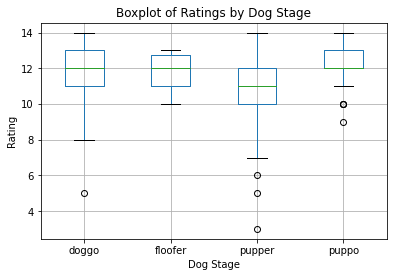

In [84]:
axes = rated_df.boxplot(column=['rating_numerator'], by='stage')
fig = axes.get_figure()
fig.suptitle('')
plt.title('Boxplot of Ratings by Dog Stage');
plt.xlabel('Dog Stage');
plt.ylabel('Rating');

There are a few things to notice here.
<ul>
    <li> The spread of the Pupper stage is the highest. Also, a lot of the outliers are on the lower end</li>
    <li> The spread of the floofer is the lowest. This is probably and indirect result of having only 10 ratings(low number or ratings) </li>
    <li> The median of the Puppo stage is about the same as its 25th percentile (meaning that at least a qurater of the Puppo ratings are that same score of about 12)</li>
    <li> The Pupper median is the lowest of all. While the rest of medians are about the same (~12)</li>

In [ ]:
1

In [ ]:
2

In [ ]:
3

In [ ]:
4

In [ ]:
5

In [ ]:
6

In [ ]:
7

In [ ]:
8

In [ ]:
9

In [ ]:
0

In [ ]:
1

In [ ]:
2

In [ ]:
3

In [ ]:
4

In [ ]:
5

In [ ]:
6

In [ ]:
7

In [ ]:
8

In [ ]:
9

[Anchor](#Anchor)

In [85]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2277
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2169 non-null   int64              
 1   in_reply_to_status_id       22 non-null     float64            
 2   in_reply_to_user_id         22 non-null     float64            
 3   timestamp                   2169 non-null   datetime64[ns, UTC]
 4   source                      2169 non-null   object             
 5   text                        2169 non-null   object             
 6   retweeted_status_id         174 non-null    float64            
 7   retweeted_status_user_id    174 non-null    float64            
 8   retweeted_status_timestamp  174 non-null    datetime64[ns, UTC]
 9   expanded_urls               2169 non-null   object             
 10  rating_numerator            2167 non-null   float64         

### Other Tidiness Issues (Outside of project requirements)

Done!
Now, to make it tidier, we would change the `variable` column to either of the following 2 values ('name' or 'stage'). As the following state is that stages are explicitly mentioned both in variable as well in the value columns. (as shown below)

In [86]:
names[names.variable != 'name'].head()

,tweet_id,variable,value
2178,890240255349198849,doggo,doggo
2210,884162670584377345,doggo,doggo
2263,872967104147763200,doggo,doggo
2272,871515927908634625,doggo,doggo
2274,871102520638267392,doggo,doggo


In [87]:
names['variable'] = names['variable']\
.apply(lambda x: x if x == 'name' else 'stage')

Fixed now!

In [88]:
names[names.variable != 'name'].head()

,tweet_id,variable,value
2178,890240255349198849,stage,doggo
2210,884162670584377345,stage,doggo
2263,872967104147763200,stage,doggo
2272,871515927908634625,stage,doggo
2274,871102520638267392,stage,doggo


Lastly, We would drop the associated columns from the `clean` dataframe

In [89]:
clean = clean.drop(['name', 'doggo', 'pupper', 'puppo', 'floofer'],
                   axis=1, errors='ignore')

In [90]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2277
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2169 non-null   int64              
 1   in_reply_to_status_id       22 non-null     float64            
 2   in_reply_to_user_id         22 non-null     float64            
 3   timestamp                   2169 non-null   datetime64[ns, UTC]
 4   source                      2169 non-null   object             
 5   text                        2169 non-null   object             
 6   retweeted_status_id         174 non-null    float64            
 7   retweeted_status_user_id    174 non-null    float64            
 8   retweeted_status_timestamp  174 non-null    datetime64[ns, UTC]
 9   expanded_urls               2169 non-null   object             
 10  rating_numerator            2167 non-null   float64         

In [91]:
names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1860 entries, 0 to 10182
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  1860 non-null   int64 
 1   variable  1860 non-null   object
 2   value     1860 non-null   object
dtypes: int64(1), object(2)
memory usage: 58.1+ KB


In [92]:
all_columns = pd.Series(list(clean) + list(predict_df) + list(tweets))
all_columns[all_columns.duplicated()]

12                 tweet_id
32                   source
33    in_reply_to_status_id
35      in_reply_to_user_id
dtype: object

The following 2 points are beyond the required number of points to address in this project (so it will be ignored for now)

##### Next, many reply-related columns like <mark>in_reply_to_status_id</mark> and <mark>in_reply_to_user_id</mark> are full of nulls (missing values). This is expected as not all tweets get replied to. These columns should be split into a separate pivoted dataframe



##### many retweet-related columns like <mark>retweeted_status_id</mark> and <mark>retweeted_status_user_id</mark> and <mark>retweeted_status_timestamp</mark> are full of nulls (missing values). This is expected as not all tweets get retweeted. These columns should be split into a separate pivoted dataframe

In [93]:
clean.to_csv('twitter_archive_master2.csv')
names.to_csv('dog_stages_and_names.csv')

# Data Analysis and Visualization

Let us start by analyzing the dog stages and their count as well as their ratings

In [94]:
clean.info()
names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2169 entries, 0 to 2277
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2169 non-null   int64              
 1   in_reply_to_status_id       22 non-null     float64            
 2   in_reply_to_user_id         22 non-null     float64            
 3   timestamp                   2169 non-null   datetime64[ns, UTC]
 4   source                      2169 non-null   object             
 5   text                        2169 non-null   object             
 6   retweeted_status_id         174 non-null    float64            
 7   retweeted_status_user_id    174 non-null    float64            
 8   retweeted_status_timestamp  174 non-null    datetime64[ns, UTC]
 9   expanded_urls               2169 non-null   object             
 10  rating_numerator            2167 non-null   float64         

To do so, we need to join the 2 tables and observe the relevant columns (names.variable, names.value, clean.rating_numerator)

In [95]:
type_df = clean[['tweet_id',
                 'rating_numerator']].merge(names,
      how='outer',
      on='tweet_id'
     )

In [96]:
type_df.info()
type_df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2378 entries, 0 to 2377
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tweet_id          2378 non-null   int64  
 1   rating_numerator  2376 non-null   float64
 2   variable          1860 non-null   object 
 3   value             1860 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 92.9+ KB


,tweet_id,rating_numerator
count,2.378000e+03,2376.000000
mean,7.452218e+17,10.760859
std,6.853554e+16,2.089644
min,6.660209e+17,0.000000
25%,6.801498e+17,10.000000
50%,7.280313e+17,11.000000
75%,8.022650e+17,12.000000
max,8.924206e+17,15.000000


In [97]:
type_df.head()

,tweet_id,rating_numerator,variable,value
0,892420643555336193,13.0,name,Phineas
1,892177421306343426,13.0,name,Tilly
2,891815181378084864,12.0,name,Archie
3,891689557279858688,13.0,name,Darla
4,891327558926688256,12.0,name,Franklin


# Anchor
[analysis](#Anaalysis)

In [98]:
number_of_ratings = type_df[(~type_df.rating_numerator.isnull()) & (type_df.variable == 'stage')].groupby('value')['variable'].value_counts().unstack().sort_values(by='stage',ascending=False) 
number_of_ratings

variable,stage
value,
pupper,238
doggo,84
puppo,29
floofer,10


As can be seen above, the most rated dog stage is pupper with 252 ratings, followed by doggo with 88 ratings, then puppo with 29 ratings, and lastly floofer with 10 ratings.

However, the number of ratings is not the only measure of popularity. Let us try to analyze the data further and see which dog stage got the highes rating scores on average.

In [99]:
total_rating_scores = type_df[(~type_df.rating_numerator.isnull()) & (type_df.variable == 'stage')].groupby('value')['rating_numerator'].sum()
total_rating_scores

value
doggo       990.00
floofer     118.00
pupper     2565.27
puppo       351.00
Name: rating_numerator, dtype: float64

In [100]:
(total_rating_scores/number_of_ratings.stage).sort_values(ascending=False)

value
puppo      12.103448
floofer    11.800000
doggo      11.785714
pupper     10.778445
dtype: float64

As can be seen above, the dog stage with the highest rating on average is puppo with an average score of 12.103, followed by floofer with an average score of 11.8, then doggo with an average score of 11.795, then finally pupper with a score of 10.823

Another way of looking at ratings is through Box Plots (Also known as Whisker Plots). These plots are useful summerizing a lot of helpful metrics like: the median, the 25th and 75th percentiles, as well as the outliers. The following is the box plot for the ratings according to their stages.

As can be seen from the box plot below, the ratings are distibuted as the following:

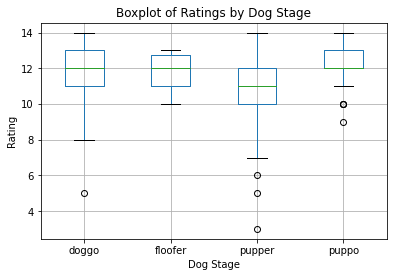

In [101]:
axes = type_df[(~type_df.rating_numerator.isnull()) & (type_df.variable == 'stage')].boxplot(column=['rating_numerator'], by='value');
fig = axes.get_figure()
fig.suptitle('')
plt.title('Boxplot of Ratings by Dog Stage');
plt.xlabel('Dog Stage');
plt.ylabel('Rating');

There are a few things to notice here.
<ul>
    <li> The spread of the Pupper stage is the highest. Also, a lot of the outliers are on the lower end</li>
    <li> The spread of the floofer is the lowest. This is probably and indirect result of having only 10 ratings(low number or ratings) </li>
    <li> The median of the Puppo stage is about the same as its 25th percentile (meaning that at least a qurater of the Puppo ratings are that same score of about 12)</li>
    <li> The Pupper median is the lowest of all. While the rest of medians are about the same (~12)</li>

[Analysis](#Anaalysis)